# MERFISH cellpose segmentation
Default output from MERSCOPE / MERLIN pipeline

Questions
- How much processing (eg filtering low quality cells) before applying metrics?
- Include count normalization? so far i only work with raw counts. Affects distribution (see last metric). If yes, use different normalization for sc and St?
- How to compare A) cell wise B) gene wise and C) single metrics?
- Which metrics to select?

Todo
- Physical distance (μm) of marker from expected cell type, as done by Allen 2023 Cell
- 3 scores from SOPA paper (Fig 3)
- see notes below



In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import spatialdata as sd
from spatialdata_io import merscope

/dss/dsshome1/0C/ra98gaq/miniconda3/envs/sdata/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/dss/dsshome1/0C/ra98gaq/miniconda3/envs/sdata/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [3]:
import sys
import os
sys.path.append(os.path.abspath("../home/src"))

In [4]:
import importlib
import metrics

In [5]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [6]:
data_dir = os.path.abspath("../home/data")
!ls -l $data_dir

lrwxrwxrwx 1 ra98gaq pn52ra 35 Feb  4 15:06 /home/data -> /dss/dssfs03/pn52re/pn52re-dss-0001


In [7]:
sample_name = "foxf2_s2_r1"

# Load sdata

In [8]:
sdata_path = os.path.join(data_dir, "cellseg-benchmark", "samples", sample_name, "sdata_z3.zarr")
if 'sdata' not in locals():
    sdata = sd.read_zarr(sdata_path)

In [9]:
sdata

SpatialData object, with associated Zarr store: /dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark/samples/foxf2_s2_r1/sdata_z3.zarr
├── Images
│     └── 'foxf2_s2_r1_z3': DataTree[cyx] (7, 54456, 65675), (7, 27228, 32837), (7, 13614, 16418), (7, 6807, 8209), (7, 3403, 4104)
├── Points
│     └── 'foxf2_s2_r1_transcripts': DataFrame with shape: (<Delayed>, 9) (2D points)
├── Shapes
│     ├── 'boundaries_Baysor_2D': GeoDataFrame shape: (124658, 1) (2D shapes)
│     ├── 'boundaries_Baysor_3D': GeoDataFrame shape: (149500, 1) (2D shapes)
│     ├── 'boundaries_Cellpose_1_DAPI_PolyT': GeoDataFrame shape: (52516, 1) (2D shapes)
│     ├── 'boundaries_Cellpose_1_DAPI_Transcripts': GeoDataFrame shape: (90915, 1) (2D shapes)
│     ├── 'boundaries_Cellpose_1_Merlin': GeoDataFrame shape: (107013, 9) (2D shapes)
│     ├── 'boundaries_Cellpose_1_nuclei_model': GeoDataFrame shape: (48759, 1) (2D shapes)
│     ├── 'boundaries_Cellpose_2_DAPI_PolyT': GeoDataFrame shape: (86547, 1) (2D shapes)
│     ├

In [10]:
table = sdata["adata_Negative_Control_Rastered_50"].copy()
table.obs.head()

,region,slide,cell_id,area
aaaaaaaa-1,image_patches,sopa_data_Foxf2_s2r1_z3,aaaaaaaa-1,213906.0
aaaaaaab-1,image_patches,sopa_data_Foxf2_s2r1_z3,aaaaaaab-1,213906.0
aaaaaaac-1,image_patches,sopa_data_Foxf2_s2r1_z3,aaaaaaac-1,213906.0
aaaaaaad-1,image_patches,sopa_data_Foxf2_s2r1_z3,aaaaaaad-1,213906.0
aaaaaaae-1,image_patches,sopa_data_Foxf2_s2r1_z3,aaaaaaae-1,213906.0


# Metrics

## Basic

In [11]:
# Tag low-quality cells

# additionally filter by volume? Done e.g. by Allen 2023 Cell (if cell volume is < 100 um3 or >3 times the median across all cells (across all experiments))

In [12]:
def compute_outlier_percentage(sdata, min_counts=25, min_genes=5):
    """Compute the percentage of outlier cells based on low counts/genes."""
    # min_counts=50 used in squidpy tutorial, 25 used in colab script from vizgen, 20 counts or 5 genes used in Allen 2023 paper
    outliers_percentage_dict = {}
    
    for name, table in sdata.tables.items():
        if name.startswith("adata_"):
            sc.pp.calculate_qc_metrics(table, qc_vars=[], percent_top=None, inplace=True)
            table.obs["cell_outlier"] = (table.obs["total_counts"] < min_counts) | (table.obs["n_genes_by_counts"] < min_genes)
            table.obs["cell_outlier"] = table.obs["cell_outlier"].astype(bool)
            outliers_count = table.obs["cell_outlier"].sum()
            outliers_percentage = (outliers_count / table.shape[0]) * 100
            outliers_percentage_dict[name.replace("adata_", "")] = outliers_percentage
    
    return outliers_percentage_dict

def count_cells(sdata):
    """Count non-outlier cells  for each table and return as dict"""
    return {name.replace("adata_", ""): table[~table.obs["cell_outlier"]].shape[0] 
            for name, table in sdata.tables.items() 
            if name.startswith("adata_")}

def mean_genes_per_cell(sdata):
    """Calculate the mean genes per cell for each table and return as dict"""
    return {name.replace("adata_", ""): table[~table.obs["cell_outlier"]].obs["n_genes_by_counts"].mean() 
            for name, table in sdata.tables.items() 
            if name.startswith("adata_")}

def mean_counts_per_cell(sdata):
    """Calculate the mean counts per cell for each table and return as dict"""
    return {name.replace("adata_", ""): table[~table.obs["cell_outlier"]].obs["total_counts"].mean() 
            for name, table in sdata.tables.items() 
            if name.startswith("adata_")}


In [104]:
# Also filter cell in "shapes" -- update on the fly, dont filter adata on disk
shape_key = list(sdata.shapes.keys())
shape_key
sdata_shapes = sdata[shape_key[0]]

sdata_shapes = sdata_shapes[sdata_shapes.index.isin(sdata['table'].obs_names)]
assert len(sdata_shapes) == len(sdata['table'].obs_names)

sdata[shape_key[0]] = sdata_shapes

/Users/simonf/miniconda3/envs/st-bsb/lib/python3.9/site-packages/spatialdata/_core/_elements.py:96: UserWarning: Key `20240322-slide02-WT-PCKO-cellpose1_region_1-536WT_polygons` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [13]:
sdata.shapes["boundaries_"+"Negative_Control_Rastered_20"]

,geometry,bboxes,ilocs
aaaaaaaa-1,"POLYGON ((22777 0, 22777 185, 22591 185, 22591...","[22591, 0, 22777, 185]","[122, 0]"
aaaaaaab-1,"POLYGON ((22962 0, 22962 185, 22777 185, 22777...","[22777, 0, 22962, 185]","[123, 0]"
aaaaaaac-1,"POLYGON ((23147 0, 23147 185, 22962 185, 22962...","[22962, 0, 23147, 185]","[124, 0]"
aaaaaaad-1,"POLYGON ((23332 0, 23332 185, 23147 185, 23147...","[23147, 0, 23332, 185]","[125, 0]"
aaaaaaae-1,"POLYGON ((23517 0, 23517 185, 23332 185, 23332...","[23332, 0, 23517, 185]","[126, 0]"
...,...,...,...
aaabfaon-1,"POLYGON ((51665 54442, 51665 54628, 51480 5462...","[51480, 54442, 51665, 54628]","[278, 294]"
aaabfaoo-1,"POLYGON ((51850 54442, 51850 54628, 51665 5462...","[51665, 54442, 51850, 54628]","[279, 294]"
aaabfaop-1,"POLYGON ((52035 54442, 52035 54628, 51850 5462...","[51850, 54442, 52035, 54628]","[280, 294]"
aaabfapa-1,"POLYGON ((52220 54442, 52220 54628, 52035 5462...","[52035, 54442, 52220, 54628]","[281, 294]"


In [14]:
import warnings
import ast
from shapely.geometry import Polygon

def mean_cell_area_2d(sdata, zindex=3):
    """Compute mean 2D cell area per dataset, excluding outlier cells, using the specified ZIndex if available."""
    mean_area_dict = {}

    for name, boundaries in sdata.shapes.items():
        if name.startswith("boundaries_"):
            table_name = name.replace("boundaries_", "adata_")  # Match table name
            if table_name not in sdata.tables:
                warnings.warn(f"Missing corresponding table {table_name} for {name}. Skipping dataset.")
                continue

            table = sdata.tables[table_name]
            if "cell_outlier" not in table.obs:
                warnings.warn(f"Missing 'cell_outlier' column in {table_name}. Using all cells.")
                valid_cells = table.obs.index  # Use all cells if no outlier info
            else:
                valid_cells = table.obs.loc[~table.obs["cell_outlier"]].index  # Exclude outliers

            if boundaries.empty or "geometry" not in boundaries:
                continue  # Skip if data is missing

            # Convert geometry from string to Polygon if needed
            boundaries = boundaries.copy()
            boundaries["geometry"] = boundaries["geometry"].apply(
                lambda x: Polygon(ast.literal_eval(x)) if isinstance(x, str) else x
            )

            # Handle ZIndex if present
            if "ZIndex" in boundaries:
                unique_z = boundaries["ZIndex"].unique()
                if len(unique_z) == 1:
                    zindex = unique_z[0]
                    warnings.warn(f"Only one z-plane detected. Setting zindex to {zindex}. Verify sdata loading if incorrect.")
                
                boundaries = boundaries[boundaries["ZIndex"] == zindex]
            else:
                warnings.warn(f"ZIndex column missing in {name}. Using the entire dataset.")

            # Filter boundaries using index
            boundaries = boundaries.loc[boundaries.index.intersection(valid_cells)]

            # Compute mean cell area
            mean_area_dict[name.replace("boundaries_", "")] = boundaries["geometry"].apply(lambda x: x.area).mean()

    return mean_area_dict


In [15]:
def combine_metrics(sdata):
    # Get the individual metrics as dicts
    outliers_dict = compute_outlier_percentage(sdata)
    cell_counts_dict = count_cells(sdata)
    mean_genes_dict = mean_genes_per_cell(sdata)
    mean_counts_dict = mean_counts_per_cell(sdata)
    mean_cell_area_2d_dict = mean_cell_area_2d(sdata)
    
    # Convert each dict into a df and join them
    outliers_df = pd.DataFrame(list(outliers_dict.items()), columns=["Dataset", "Outlier Percentage"]).set_index("Dataset")
    cell_counts_df = pd.DataFrame(list(cell_counts_dict.items()), columns=["Dataset", "Cell Count"]).set_index("Dataset")
    mean_genes_df = pd.DataFrame(list(mean_genes_dict.items()), columns=["Dataset", "Mean Genes per Cell"]).set_index("Dataset")
    mean_counts_df = pd.DataFrame(list(mean_counts_dict.items()), columns=["Dataset", "Mean Counts per Cell"]).set_index("Dataset")
    mean_cell_area_2d_df = pd.DataFrame(list(mean_cell_area_2d_dict.items()), columns=["Dataset", "Mean Cell Area 2D"]).set_index("Dataset")
    
    # Merge all dfs on the 'Dataset' index
    combined_df = outliers_df.join([cell_counts_df, mean_genes_df, mean_counts_df, mean_cell_area_2d_df])
    
    return combined_df

In [16]:
combined_df = combine_metrics(sdata)
combined_df

,Outlier Percentage,Cell Count,Mean Genes per Cell,Mean Counts per Cell,Mean Cell Area 2D
Dataset,,,,,
Baysor_2D,16.650355,103902,42.350744,104.899415,165.428459
Baysor_3D,0.524415,148716,93.863256,439.665893,142.240132
Cellpose_1_DAPI_PolyT,1.685201,51631,148.802619,796.398791,17065.250473
Cellpose_1_DAPI_Transcripts,3.939944,87333,122.402242,681.208501,18896.384728
Cellpose_1_Merlin,29.318868,75638,128.934980,648.700521,165.135701
Cellpose_1_nuclei_model,1.443836,48055,146.917990,740.064176,11751.518449
Cellpose_2_DAPI_PolyT,3.918102,83156,124.196390,661.050748,16417.217945
Cellpose_2_DAPI_Transcripts,6.929662,117962,99.253539,506.711865,13921.807236
ComSeg,0.242849,48061,192.155656,1308.852812,375.125762


In [105]:
# cell area in 2D (single z stack)

In [106]:
shape_key = list(sdata.shapes.keys())
shape_key

['20240322-slide02-WT-PCKO-cellpose1_region_1-536WT_polygons']

In [107]:
#sdata[shape_key[0]].head(2)

In [108]:
area2d = metrics.cell_area_2d(boundaries=sdata[shape_key[0]],
                              zindex=3
                             )

/Users/simonf/PhD/Git-MacOS/st-bsb/src/metrics/basic.py:25: UserWarning: Only one z-plane detected. Setting zindex to 0. Verify sdata loading if incorrect.
  warnings.warn(f"Only one z-plane detected. Setting zindex to {zindex}. Verify sdata loading if incorrect.")


In [109]:
area2d.head(3)

,area
1865558700003100722,148.171966
1865558700003100738,209.011163
1865558700004100131,184.291769


In [111]:
#importlib.reload(metrics.basic)

In [120]:
# compare to default MERLIN output: 3D volume (all z stacks)
sdata["table"].obs['volume'].head(2)

EntityID
1865558700003100722    1555.805640
1865558700003100738    2194.617216
Name: volume, dtype: float64

In [121]:
area3d = pd.DataFrame(sdata["table"].obs['volume'])
area2d.index = area2d.index.astype(int)
area3d.index = area3d.index.astype(int)

In [122]:
area2d['area'].corr(area3d['volume'])

0.9997771333253247

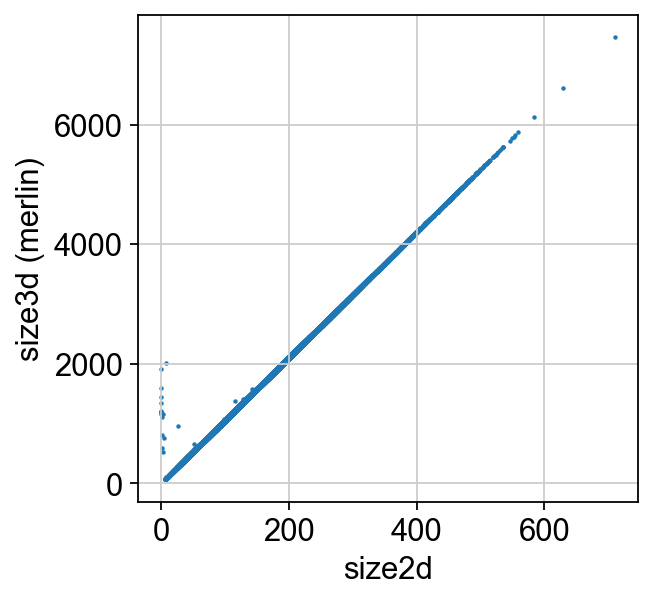

In [123]:
plt.scatter(area2d['area'], area3d['volume'], s=1)
plt.xlabel('size2d')
plt.ylabel('size3d (merlin)')
plt.show()

## Number of doublets

In [116]:
sc.pp.scrublet(sdata["table"])

/Users/simonf/miniconda3/envs/st-bsb/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [119]:
sdata["table"].obs['predicted_doublet'].sum()

3

## Transcript density

In [124]:
transcript_density = metrics.transcript_density_3d(cell_volume_3d = area2d['area']*7, # assumption is that all z planes have same segmentation
                                           n_transcripts = n_transcripts
                                          )
transcript_density.head(2)

1865558700003100722    0.675856
1865558700003100738    0.573449
dtype: float64

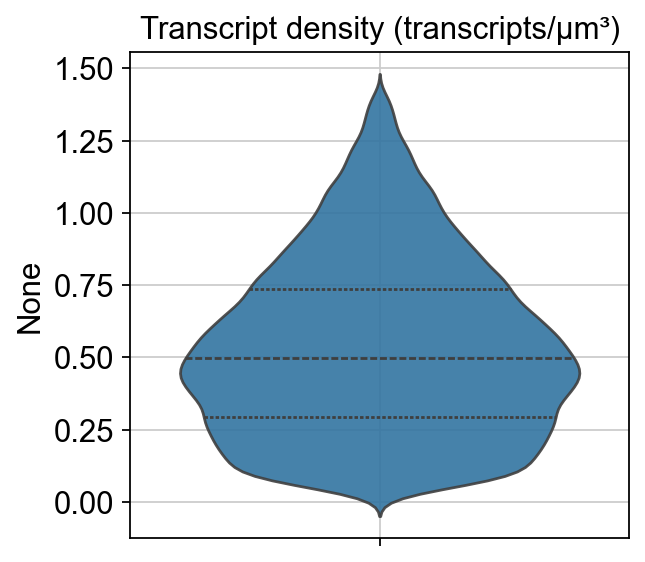

In [125]:
sns.violinplot(y=transcript_density[
                   transcript_density <= np.percentile(transcript_density, 99)
                   ], 
               alpha=0.9, inner="quart", zorder=2)
plt.title('Transcript density (transcripts/µm³)')
plt.grid(True, zorder=0)
plt.show()

## Transcripts per z plane

In [22]:
points_keys = list(sdata.points.keys())
points_keys

['20240322-slide02-WT-PCKO-cellpose1_region_1-536WT_transcripts']

In [23]:
from spatialdata.models import PointsModel
parsed_points = PointsModel.parse(sdata[points_keys[0]], sort=True)
temp = parsed_points.compute()[["x", "y", "cell_id", "gene", "global_z"]]

In [24]:
temp.head()

,x,y,cell_id,gene,global_z
0,7136.4756,2356.3298,1865558700069100825,Igf2,0.0
1,7138.1094,2360.3838,1865558700069100825,Cfp,0.0
2,7136.9727,2356.9917,1865558700069100825,Slc3a2,0.0
3,7135.1360,2357.4858,1865558700069100825,Slc3a2,0.0
4,7137.8364,2359.2458,1865558700069100825,Slc47a1,0.0


In [25]:
temp.global_z.unique()

array([0., 1., 2., 4., 5., 6., 3.])

In [27]:
temp.global_z.value_counts().sort_index()

global_z
0.0    11244109
1.0    11853054
2.0    11840197
3.0    11368572
4.0     9883842
5.0     6853125
6.0     3633456
Name: count, dtype: int64

## Unassigned transcripts

In [11]:
points_keys = list(sdata.points.keys())
points_keys

['20240322-slide02-WT-PCKO-cellpose1_region_1-536WT_transcripts']

In [12]:
from spatialdata.models import PointsModel
parsed_points = PointsModel.parse(sdata[points_keys[0]], sort=True)
transcripts_df = parsed_points.compute()[["x", "y", "cell_id", "gene"]]

In [13]:
transcripts_df.head(2)

,x,y,cell_id,gene
0,7136.4756,2356.3298,1865558700069100825,Igf2
1,7138.1094,2360.3838,1865558700069100825,Cfp


In [14]:
metrics.pct_unassigned_transcripts(transcripts_df)

25.93

## Top segmented genes

In [31]:
top_unsegmented_genes = metrics.top_unsegmented_genes(transcripts_df)

In [32]:
top_unsegmented_genes

,segmented_count,unsegmented_count,total_count,unsegmented_proportion
Mbp,5152281,5544154,10696435,0.52
S100b,196094,195748,391842,0.50
Apoe,607190,571617,1178807,0.48
Gfap,183100,166085,349185,0.48
Clu,290826,228049,518875,0.44
...,...,...,...,...
Runx2,17814,907,18721,0.05
Slc22a2,12038,681,12719,0.05
Atp13a5,30199,1180,31379,0.04
Cfp,27103,839,27942,0.03


## Marker FPR / specificity

In [177]:
import scanpy as sc

In [178]:
# process sc pipeline for clustering
sdata["table"].layers["counts"] = sdata["table"].X
sc.pp.normalize_total(sdata["table"])
sc.pp.log1p(sdata["table"])
sdata["table"].layers["librarysize_log1p_norm"] = sdata["table"].X
sc.pp.highly_variable_genes(sdata["table"], n_top_genes=2000)
sc.tl.pca(sdata["table"])
sc.pp.neighbors(sdata["table"])
sc.tl.umap(sdata["table"])

/Users/simonf/miniconda3/envs/st-bsb/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/Users/simonf/miniconda3/envs/st-bsb/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [179]:
sdata["table"].layers

Layers with keys: counts, librarysize_log1p_norm

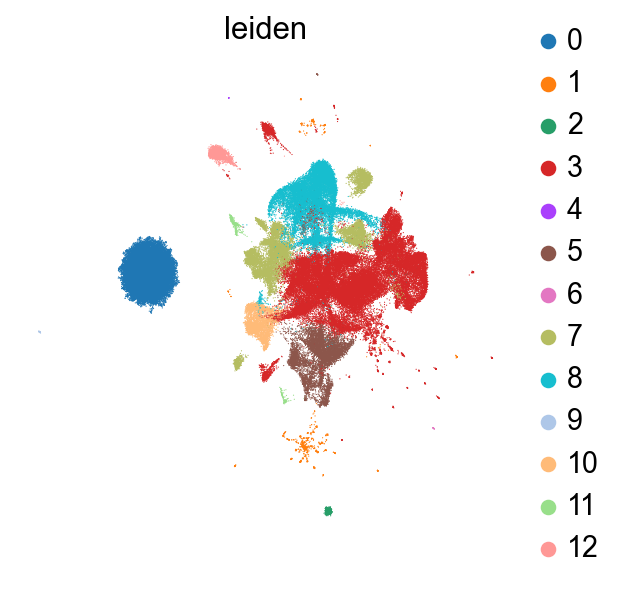

In [180]:
sc.tl.leiden(sdata["table"], flavor="igraph", resolution=0.1)
sc.pl.umap(sdata["table"], color=["leiden"])

In [181]:
# Generate random simulated cell type labels
random_labels = np.random.choice([f'Group_{i+1}' for i in range(13)], size=sdata["table"].obs.shape[0])
sdata["table"].obs['random_label'] = random_labels

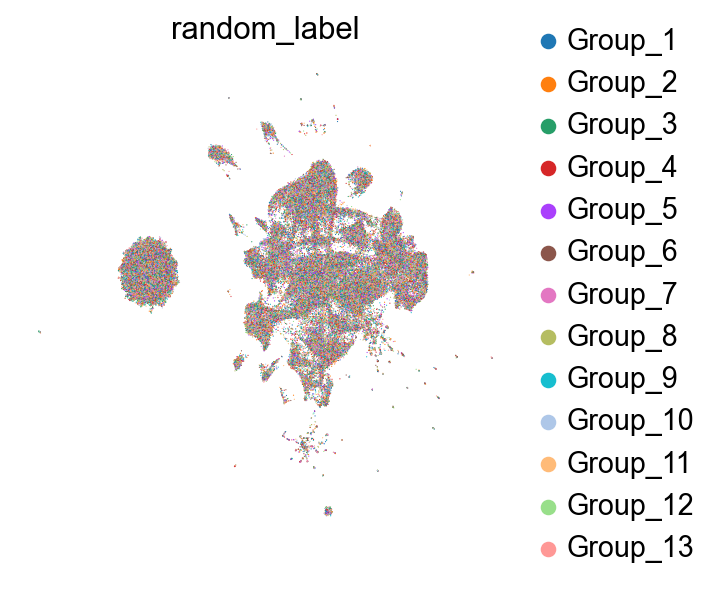

In [182]:
sc.pl.umap(sdata["table"], color=["random_label"])

In [335]:
target_marker = "Cldn5"

In [286]:
target_marker = "Tagln"

In [380]:
import metrics.specificity

In [383]:
x = metrics.specificity.calculate_marker_specificity_sensitivity(adata=sdata["table"],
                                                                 target_marker="Cldn5",
                                                                 groupby="leiden",
                                                                 target_cluster='5'
                                                                )

In [384]:
x

{'marker': 'Cldn5',
 'group': 'leiden',
 'target_cluster': '5',
 'expression_threshold': 0,
 'metrics': {'FPR': 0.058,
  'specificity': 0.942,
  'sensitivity': 0.782,
  'PPV': 0.505,
  'NPV': 0.983}}

In [385]:
x = metrics.specificity.calculate_marker_specificity_sensitivity(adata=sdata["table"],
                                                                 target_marker="Cldn5",
                                                                 groupby="random_label",
                                                                 target_cluster='Group_10'
                                                                )

In [386]:
x

{'marker': 'Cldn5',
 'group': 'random_label',
 'target_cluster': 'Group_10',
 'expression_threshold': 0,
 'metrics': {'FPR': 0.109,
  'specificity': 0.891,
  'sensitivity': 0.106,
  'PPV': 0.074,
  'NPV': 0.924}}

In [ ]:
# key metrics: FPR and sensitivity

## Marker enrichment

Todo: Use sum of transcripts per group to be able to be compatible with FICTURE

Proportion of transcripts in expected cluster vs. other clusters  
Effectively == FC


In [388]:
sc.tl.rank_genes_groups(sdata["table"], group="5", groupby="leiden", method='wilcoxon')

In [400]:
rank = sc.get.rank_genes_groups_df(sdata["table"], group="5")
rank

,names,scores,logfoldchanges,pvals,pvals_adj
0,Flt1,120.588974,11.408150,0.000000e+00,0.000000e+00
1,Epas1,117.150620,15.165833,0.000000e+00,0.000000e+00
2,Eng,114.533363,9.336301,0.000000e+00,0.000000e+00
3,Rgs5,111.468399,17.904018,0.000000e+00,0.000000e+00
4,Abcb1a,111.294403,10.169430,0.000000e+00,0.000000e+00
...,...,...,...,...,...
495,Ptprd,-23.557770,-2.160015,1.045076e-122,3.786506e-122
496,Slc7a14,-24.850861,-3.454920,2.531052e-136,9.587317e-136
497,Mog,-25.110411,-2.389013,3.827910e-139,1.461035e-138
498,Slc4a10,-27.528532,-4.304514,7.999014e-167,3.278284e-166


In [405]:
np.exp(rank["logfoldchanges"]) # FC

0      9.005265e+04
1      3.858671e+06
2      1.134237e+04
3      5.965082e+07
4      2.609319e+04
           ...     
495    1.153234e-01
496    3.158984e-02
497    9.172014e-02
498    1.350744e-02
499    8.768668e-03
Name: logfoldchanges, Length: 500, dtype: float32

## Compare marker distributions  
Within and outside of targer cluster

Todo: Use specific known marker

Todo: Dendent on normaloizatin?

In [535]:
import metrics.wasserstein

In [536]:
y = metrics.wasserstein.calculate_wasserstein_distance(adata=sdata["table"],
                                                       target_cluster='5',
                                                       groupby='leiden',
                                                       layer='librarysize_log1p_norm'
                                                      )

In [537]:
y

,gene,distance
0,Rgs5,1.801509
1,Epas1,1.703756
2,Cldn5,1.634957
3,Flt1,1.623037
4,Abcb1a,1.415774
...,...,...
495,Casz1,0.005500
496,Pifo,0.004543
497,Folr1,0.003865
498,Dll3,0.003619


In [ ]:
# plot selected genes

In [444]:
target_marker = "Flt1"

In [521]:
target_marker = "Rgs5"

In [522]:
groupby="leiden"
target_cluster='5'
layer = "librarysize_log1p_norm"

In [525]:
adata = sdata["table"]
adata.X = adata.layers[layer]
target_marker_adata = adata[:, adata.var_names.str.match(target_marker)]
cells_cluster = adata[adata.obs[groupby] == target_cluster].obs_names
cells_other = adata[adata.obs[groupby] != target_cluster].obs_names
adata_cluster = target_marker_adata[cells_cluster]
adata_other = target_marker_adata[cells_other]

<Axes: ylabel='Count'>

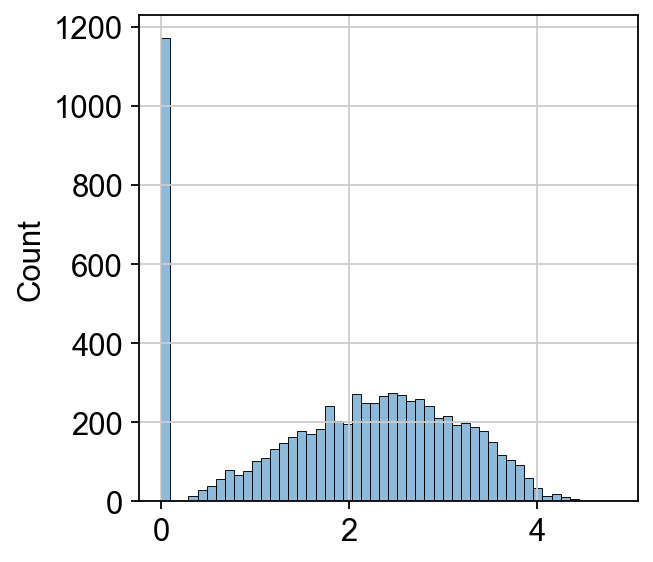

In [530]:
sns.histplot(adata_cluster.X, bins=50, legend=False)

<Axes: ylabel='Count'>

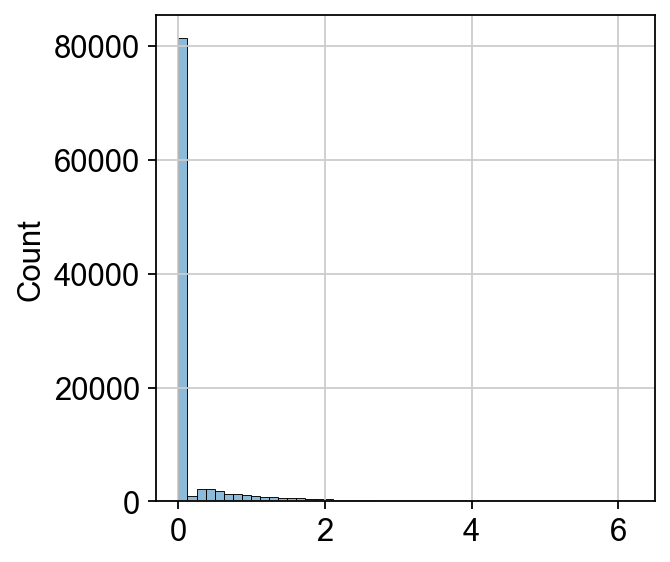

In [531]:
sns.histplot(adata_other.X, bins=50, legend=False)

# Outdated
Loading as adata

## adata

In [ ]:
adata = sq.read.vizgen(
            path=dir_merfish,
            counts_file="cell_by_gene.csv", 
            meta_file="cell_metadata.csv"
        )

In [ ]:
adata.var_names_make_unique()

In [ ]:
adata

In [ ]:
adata.uns['spatial']

In [ ]:
adata.obsm['spatial']

## cell boundaries  
Parquet file

In [ ]:
boundaries = pd.read_parquet(os.path.join(dir_merfish,'cell_boundaries.parquet'))
boundaries.head(2)

In [ ]:
boundaries.ZIndex.unique()

## transcript positions

In [ ]:
transcript_positions = pd.read_csv(os.path.join(dir_merfish,'detected_transcripts.csv'))
transcript_positions.shape

In [ ]:
transcript_positions.head(3)

In [ ]:
# ["cell_id"] == -1 if not associated with any cell

In [ ]:
(transcript_positions["cell_id"] == -1).sum()